# Cut matched catalog and calculate selection function

1. Works out the failure fraction of galaxies without Sersic mass estimate and creates an interpolation object corresponding to this survival function.
2. Calculates the HI survival function from Mike's data
3. Calculate the RFI survival probability from Mike's data
4. Calculate the SDSS survival function for NSA catalog
5. Inspect the distribution of the matched catalog
6. Apply selection function to the rand catalog



In [88]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
from scipy.stats import binned_statistic
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.io import fits, ascii
from time import time
import Setup as p

plt.rcParams['font.serif']='Times New Roman' # Text font
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.size']=7
plt.rcParams['text.usetex']=False
plt.rcParams['mathtext.fontset']='cm' #Computer Modern font
figwidth=3.4 # PRD column width in inches
aspect = 0.75 # Aspect ratio
figheight = aspect*figwidth


cat = fits.open("../../BAM/a100springfull.fits")[1].data
logMH = cat['logMH']
MS = cat['SERSIC_MASS']
RA = cat['RAdeg_HI']
DEC = cat['DECdeg_HI']
Dist = cat['Dist']
logW50 = cat['W50']

h=0.688
# h=1
H0 = 100*h

save_plots = False

## 1. Calculate the failure rate -> survival function

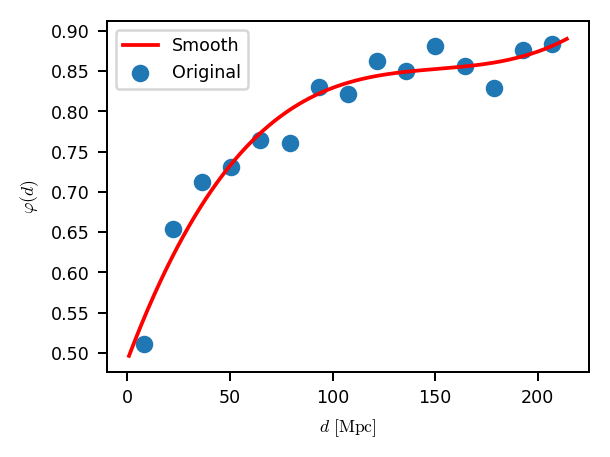

In [94]:
nbins = 15
bins = np.linspace(np.min(Dist), np.max(Dist), nbins+1)

# Find the missing galaxies
IDS = np.where(np.isfinite(MS)==False)
# Grab their distance
remDist = Dist[IDS]

# Bin removed galaxies and all galaxies into bins of distance
counts = binned_statistic(Dist, Dist, statistic='count', bins=bins)[0]
countsRem = binned_statistic(remDist, remDist, statistic='count', bins=bins)[0]

# Get the selection function for failure rate
x = p.bin_centers(bins)
y = 1-countsRem/counts

# Smooth out the points
yhat = savgol_filter(y, 15, 3)
# Create an interpolation object from the smoothed points
survival_func_failure = interp1d(x, yhat, kind='cubic', fill_value='extrapolate')

# For a quick check make a plot
t = np.linspace(np.min(Dist), np.max(Dist), 2500)

plt.figure(figsize=(figwidth,figheight),dpi=180)
plt.scatter(x,y, label='Original')
plt.plot(t, survival_func_failure(t), label='Smooth', c='red')
plt.xlabel(r"$d\ [\mathrm{Mpc}]$")
plt.ylabel(r"$\varphi (d)$")
plt.tight_layout()
plt.legend()
if save_plots:
    plt.savefig("../../Plots/SurvFailure.png", dpi=240)
plt.show()

## 2. Calculate HI selection function

Selection function equation:

$\varphi(d)= \dfrac{\int_{w_{50, m i n}}^{w_{50, \max }} \int_{m_{H I, l i m}\left(d, w_{50}\right)}^{m_{H I, m a x}} n\left(m_{H I}, w_{50}\right) d m_{H I} d w_{50}}{\int_{w_{50, m i n}}^{w_{50, \max }} \int_{m_{H I, m i n}}^{m_{H I, m a x}} n\left(m_{H I}, w_{50}\right) d m_{H I} d w_{50}}$

What are the limits on HI mass and W50 in the catalog?

In [95]:
print(np.min(logW50), np.max(logW50))
print(np.min(logMH), np.max(logMH))

16 885
6.07 10.85


1.0
1.0
1.0
1.0
1.0
1.0


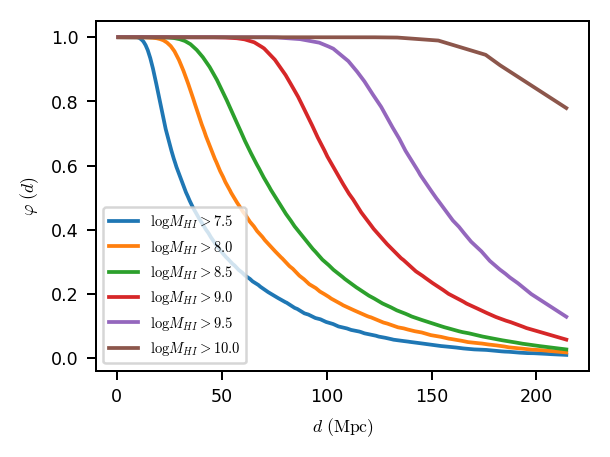

In [96]:
# Load Mike's data
MFWascii = ascii.read("../../Data/HIdata/a100.180315.MWF.csv")
MFW = np.zeros(shape=(25, 18))
for i in range(25):
    for j in range(18):
        MFW[i, j] = MFWascii[i][j]

massbins = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2,
            8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0]
w50bins = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]

# Func to calculate m_HI,lim(d, w50). Might have to be checked but should be correct
def limit_logMH(d, w50):
    if w50 <= 2.5:
        logflux = 0.5*w50-1.207
    elif w50 > 2.5:
        logflux = w50-2.457
    return 5.372+logflux+2*np.log10(d)

def surv_dist_HI(dist, minmass):
    res = 0
    norm = 0
    mlow_ind = np.abs(minmass-np.array(massbins)).argmin()

    for i in range(len(w50bins)-1):
        dw50 = w50bins[i+1]-w50bins[i]
        w50 = (w50bins[i+1]+w50bins[i])/2

        mlim = limit_logMH(dist, w50)

        mlim_ind = np.abs(mlim-np.array(massbins)).argmin()

        if mlim < minmass:
            xi = mlow_ind
        else:
            xi = mlim_ind

        for j in range(xi, len(massbins)-1):
            dm = massbins[j+1]-massbins[j]
            res += MFW[j, i]*dm*dw50

        for j in range(mlow_ind, len(massbins)-1):
            dm = massbins[j+1]-massbins[j]
            norm += MFW[j, i]*dm*dw50

    return res/norm

def survival_func_HI(dist_arr, mlim, points):
    y = np.array([surv_dist_HI(i, mlim) for i in dist_arr])
    # Apply filter
    yhat = savgol_filter(y, points, 1)
    # Interpolate the filter
    f = interp1d(dist_arr, yhat)
    return f

# Make a plot
mlims = [7.5, 8, 8.5, 9, 9.5, 10]
smoothpoints = [101, 151, 301, 351, 401, 751]
yy = list()
for mlim, points in zip(mlims, smoothpoints):
    fint = survival_func_HI(t, mlim, points)
    y = fint(t)
    yy.append(y)
    print(np.max(y))


# Make a plot
plt.figure(figsize=(figwidth,figheight),dpi=180)
for mlim, y in zip(mlims, yy):
    plt.plot(t, y, label=r"$\log M_{{HI}}>{{{:.1f}}}$".format(mlim))
plt.xlabel(r"$d\ (\mathrm{Mpc})$")
plt.ylabel(r"$\varphi\ (d)$") 
plt.legend(fontsize='small')
plt.tight_layout()
# plt.ylim(0.0-0.1, 1.0+0.1)
if save_plots:
    plt.savefig("../../Plots/HIsurf_smooth.pdf", dpi=180)
plt.show()

# fontsize : int or float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}

## 3. Calculate RFI survival

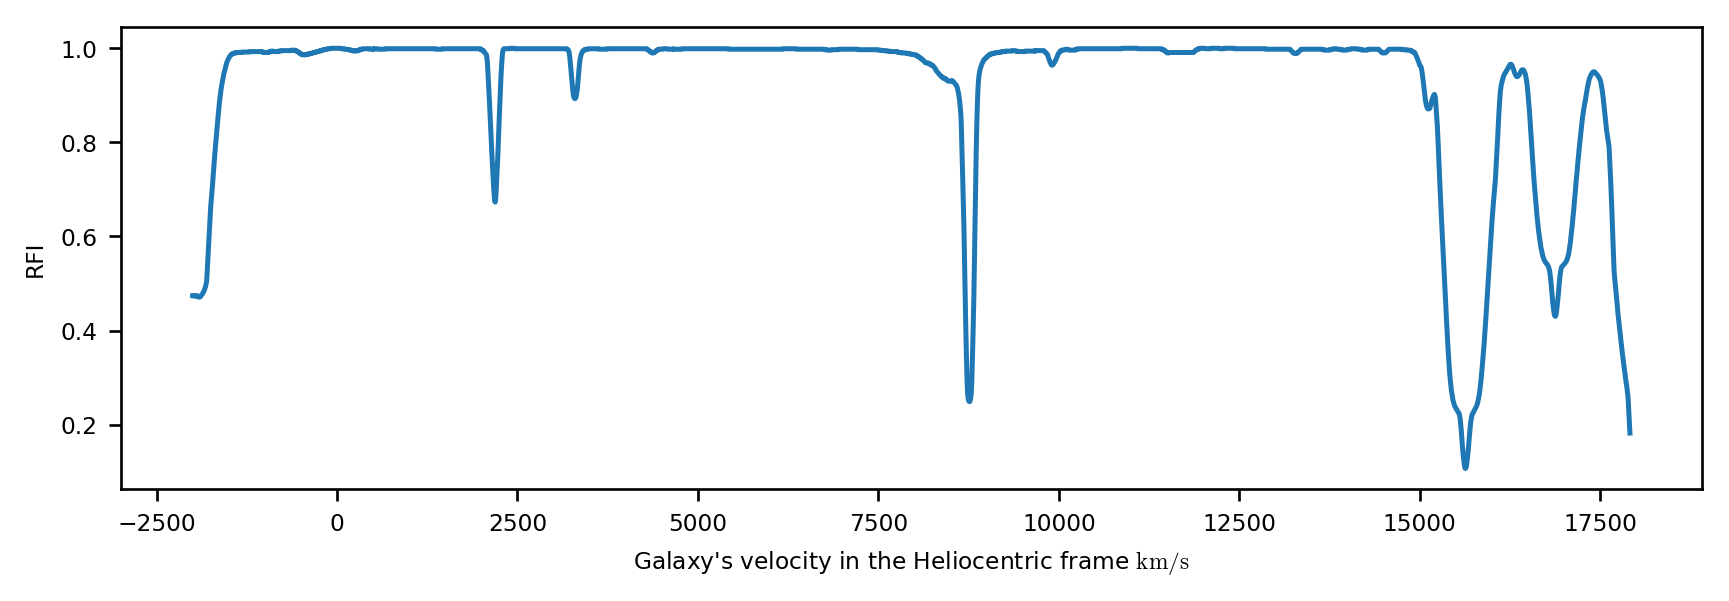

In [97]:
# Sun's velocity vector
vsun = 369
phi_sun = (11+11/60+57/60**2)*np.pi/12
theta_sun = np.pi/2-np.deg2rad(7.22)
sun_vect = vsun*np.array([np.sin(theta_sun)*np.cos(phi_sun),
                     np.sin(theta_sun)*np.sin(phi_sun),
                     np.cos(theta_sun)])

def heliovelocity(pars):
    # Unpack parameters
    RAcmb, DECcmb, distcmb = pars
    phi_cmb = float(RAcmb)
    theta_cmb = np.pi/2-float(DECcmb)
    vcmb = H0*distcmb
    # Get the cmb vect in cartesian coordinates
    cmb_vect = vcmb*np.array([np.sin(theta_cmb)*np.cos(phi_cmb),
                         np.sin(theta_cmb)*np.sin(phi_cmb),
                         np.cos(theta_cmb)])

    # Substract the two vectors
    vel_helio = cmb_vect-sun_vect
    # Extract the radial component
    vel_helio_r = np.sin(theta_cmb)*(vel_helio[0]*np.cos(phi_cmb)+vel_helio[1]*np.sin(phi_cmb))\
                    + vel_helio[2]*np.cos(theta_cmb)
    
    return vel_helio_r

dataRFI = ascii.read("../../Data/HIdata/rfi_frac.ascii")

rfi_hvel = np.array(dataRFI['Vhelio'])
rfi = np.array(dataRFI['fRFI'])

survival_func_rfi = interp1d(rfi_hvel, rfi)

plt.figure(figsize=(2.5*figwidth,figheight),dpi=240)
plt.plot(rfi_hvel, rfi)
plt.xlabel(r"Galaxy's velocity in the Heliocentric frame $\mathrm{km}/\mathrm{s}$")
plt.ylabel("RFI")
plt.show()

## 4. Calculate the SDSS survival function

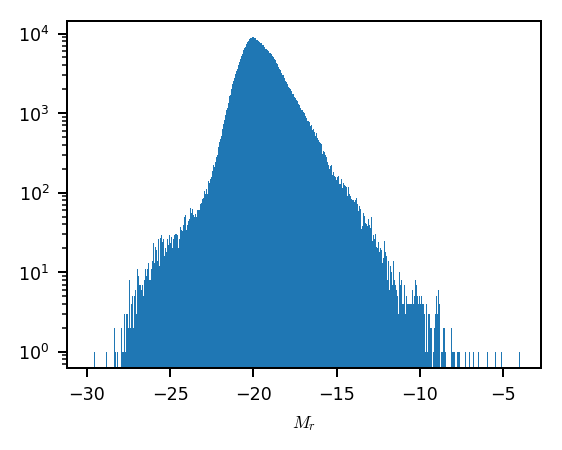

In [98]:
dataLF = np.loadtxt("../../Data/SMmatching/LF_Ser.dat")
catSDSS = fits.open("../../BAM/Old/nsa_v1.fits")[1].data

logMSlim = 9.8-2*np.log10(0.688)


# Take the r-band absolute magnitude and eliminate galaxies with no stellar mass estimate
absmag = catSDSS['SERSIC_ABSMAG'][:, 4]-5*np.log10(h)
mass = catSDSS['SERSIC_MASS']
IDS = np.where(np.isfinite(mass))
mass = mass[IDS]
absmag = absmag[IDS]

IDS = np.where(mass > 0.0)
logmass = np.log10(mass[IDS])-2*np.log10(h)
absmag = absmag[IDS]

IDS = np.where(absmag>-30)
logmass = logmass[IDS]
absmag = absmag[IDS]


plt.figure(figsize=(figwidth,figheight),dpi=180)
plt.hist(absmag, bins='auto', log=True)
plt.xlabel(r"$M_r$")
if save_plots:
    plt.savefig("../../Plots/NSA_Mr_hist.png", dpi=240)
plt.show()

### Calculate binned statistics for mapping stellar mass to abs mag

Stellar mass cut of 10.124823123528978 corresponds to abs. mag cut of -18.890118771811885


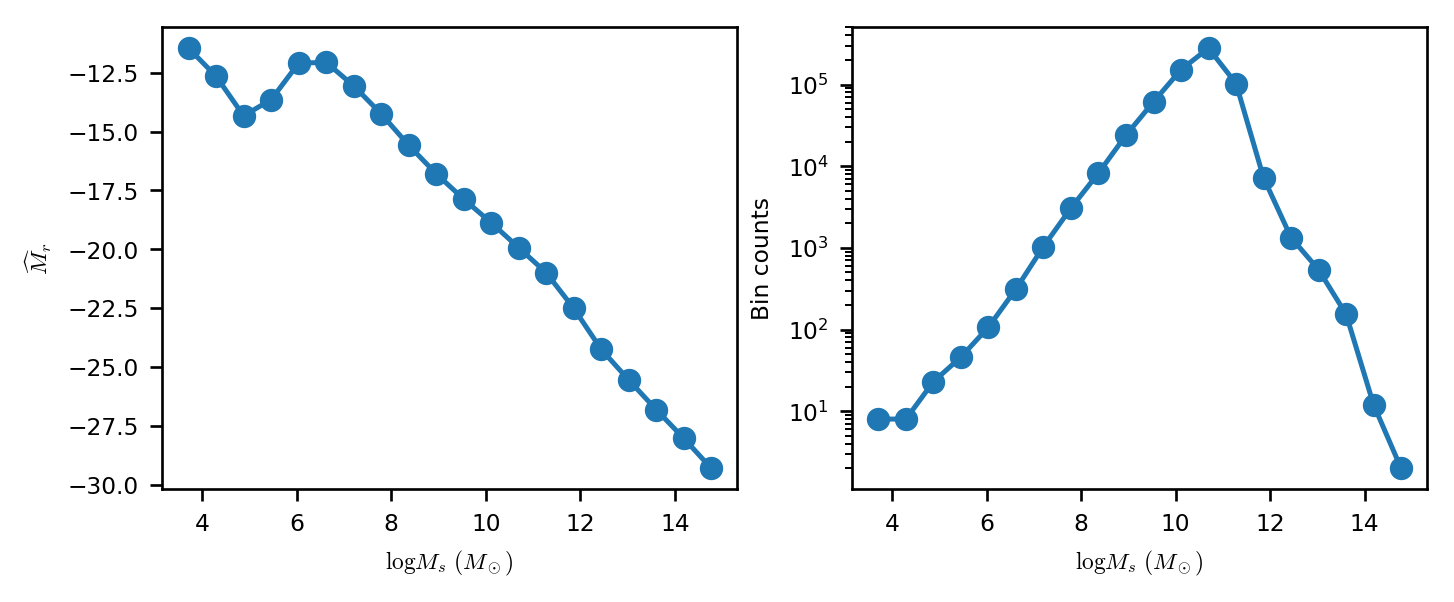

In [99]:
binmag, mbins, __ = binned_statistic(logmass, absmag, bins=20)
bincount, __, __ = binned_statistic(logmass, absmag, bins=20, statistic='count')
xbins = p.bin_centers(mbins)


logmass2absmag_func = interp1d(xbins, binmag, kind='cubic')

absmag_faintlim = logmass2absmag_func(logMSlim)
print(r"Stellar mass cut of {} corresponds to abs. mag cut of {}".format(logMSlim, absmag_faintlim))


plt.figure(figsize=(2*figwidth,figheight),dpi=240)

plt.subplot(121)
plt.plot(xbins, binmag, marker='o')
plt.xlabel(r"$\log M_s\ (M_\odot)$")
plt.ylabel(r"$\widehat{M}_r$")

plt.subplot(122)
plt.semilogy(xbins, bincount, marker='o')
plt.xlabel(r"$\log M_s\ (M_\odot)$")
plt.ylabel("Bin counts")


plt.show()

### Interpolate the gal. luminosity function

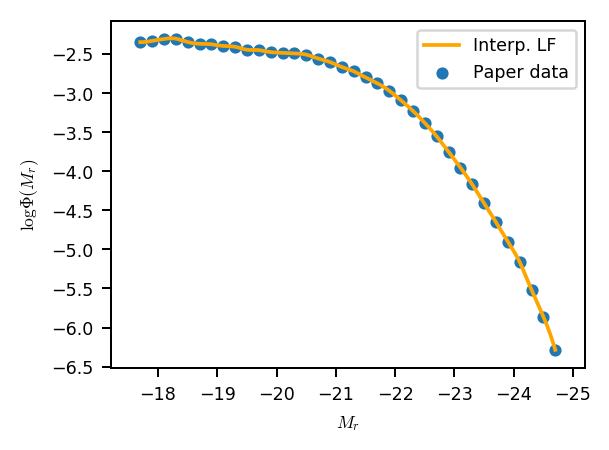

In [100]:
xLF = dataLF[:, 0]
yLF = dataLF[:, 1]


# Interpolate the galaxy luminosity function
nlum = interp1d(xLF, yLF, kind='cubic')
t = np.linspace(xLF.min(), xLF.max(), 1000)


plt.figure(figsize=(figwidth,figheight),dpi=180)
plt.plot(t, nlum(t), color='orange', label="Interp. LF")
plt.scatter(xLF, yLF, marker='o', s=15, label="Paper data")
plt.xlim(np.max(xLF)+0.5, np.min(xLF)-0.5)
plt.ylabel(r"$\log \Phi (M_r)$")
plt.xlabel(r"$M_r$")
plt.legend()
plt.show()

### Extrapolate the faint and bright end

/mnt/zfsusers/rstiskalek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


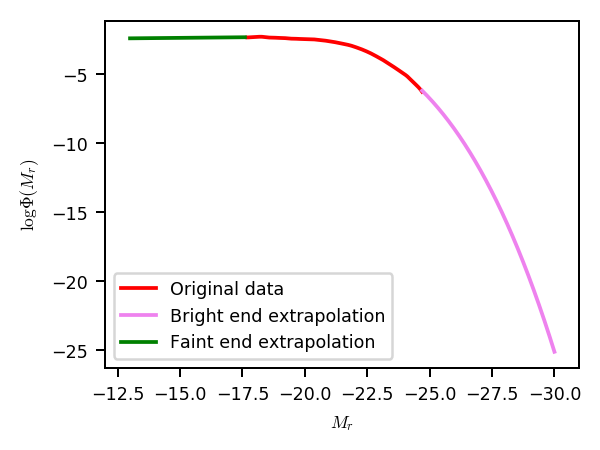

In [101]:
def bright_end_func(x, a, b, c, d):
    return -np.exp(a*x+b) + c*x + d

def faint_end_func(x, a, b):
    return a*x+b

bright_end_coef = curve_fit(bright_end_func, xLF[:27], yLF[:27], [[1, 0, 0, 0]], maxfev=100000)[0]
s = slice(-5, None)
faint_end_coef = curve_fit(faint_end_func, xLF[s], yLF[s], [0, 0], maxfev=100000)[0]


tbright = np.linspace(-24.7, -30, 250)
a, b, c, d = bright_end_coef
ybright = [bright_end_func(i, a, b, c, d) for i in tbright]

tfaint=np.linspace(-17.6, -13, 250)
a, b = faint_end_coef
yfaint = [faint_end_func(i, a, b) for i in tfaint]

y = nlum(t)

plt.figure(figsize=(figwidth,figheight),dpi=180)
# plt.rcParams.update({'font.size': 8})
plt.plot(t, y, c='red', label='Original data')
plt.plot(tbright, ybright, c='violet', label='Bright end extrapolation')
plt.plot(tfaint, yfaint, c='green', label='Faint end extrapolation')
plt.xlim(-12, -31)
plt.ylabel(r"$\log \Phi (M_r)$")
plt.xlabel(r"$M_r$")
plt.legend()
if save_plots:
    plt.savefig("../../Plots/GalLumExtrapolate.png", dpi=240)
plt.show()

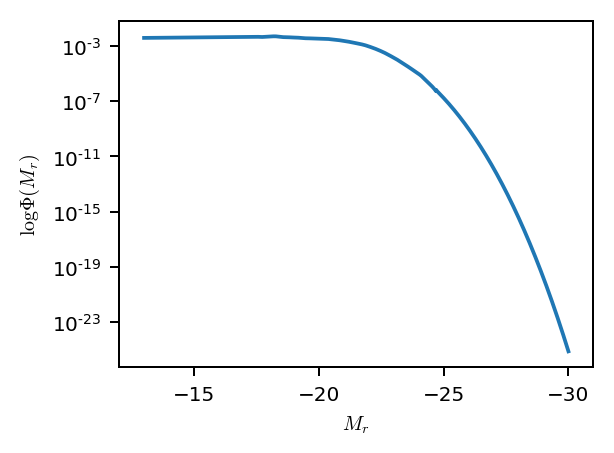

In [102]:
xx = np.hstack([tfaint, t, tbright])
yy = np.hstack([yfaint, y, ybright])

IDS = np.argsort(xx)
xx = xx[IDS]
yy = yy[IDS]

IDS = np.unique(xx, return_index=True)[1]
xx = xx[IDS]
yy = yy[IDS]


nlum = interp1d(xx, 10**yy, kind='cubic')

h = np.linspace(xx.min(), xx.max(), 10000)

plt.figure(figsize=(figwidth,figheight),dpi=180)
# plt.scatter(x,y, s=15, marker='x')
plt.rcParams.update({'font.size': 8})
plt.semilogy(h, nlum(h))
plt.xlim(xx.max()+1, xx.min()-1)
plt.ylabel(r"$\log \Phi (M_r)$")
plt.xlabel(r"$M_r$")
plt.show()

In [103]:
def absmag_dist(d):
    # Distance in Mpc
    appmag_lim = 17.6
    return appmag_lim -25 -  5*np.log10(d)

faintest_absmag = absmag_faintlim
brightest_absmag = np.min(absmag)

print(faintest_absmag, brightest_absmag)

print(faintest_absmag, absmag_dist(150))

-18.890118771811885 -29.9087
-18.890118771811885 -18.2804562953


In [104]:
norm = quad(nlum, faintest_absmag, brightest_absmag)[0]
def surv_dist(d):
    sdsslim = absmag_dist(d)
    # If SDSS lim is less bright than faintest sdss object return 1.0
    if sdsslim > faintest_absmag:
        return 1.0
    else:
        integ = quad(nlum, sdsslim, brightest_absmag, limit=100, epsabs=1.49e-5)
        if integ[1] > 1e-3:
            print("Hmm, having problems")
    return integ[0]/norm



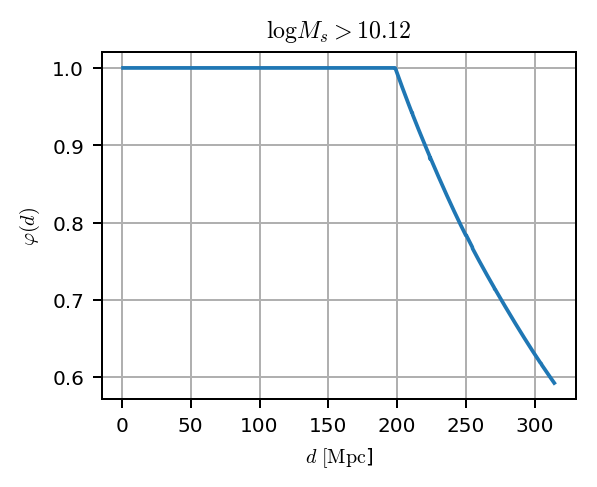

In [105]:
xx = np.linspace(Dist.min(), Dist.max()+100, 1000)
yy = np.array([surv_dist(i) for i in xx])

plt.figure(figsize=(figwidth,figheight),dpi=180)
plt.plot(xx, yy)
plt.grid()
plt.xlabel(r"$d\ [\mathrm{Mpc}$]")
plt.ylabel(r"$\varphi(d)$")
plt.title(r"$\log M_s>{:.2f}$".format(logMSlim))
if save_plots:
    plt.savefig("../../Plots/SDSSsurv.png", dpi=240)
plt.show()

## 5. Inspect the distribution of the matched catalog

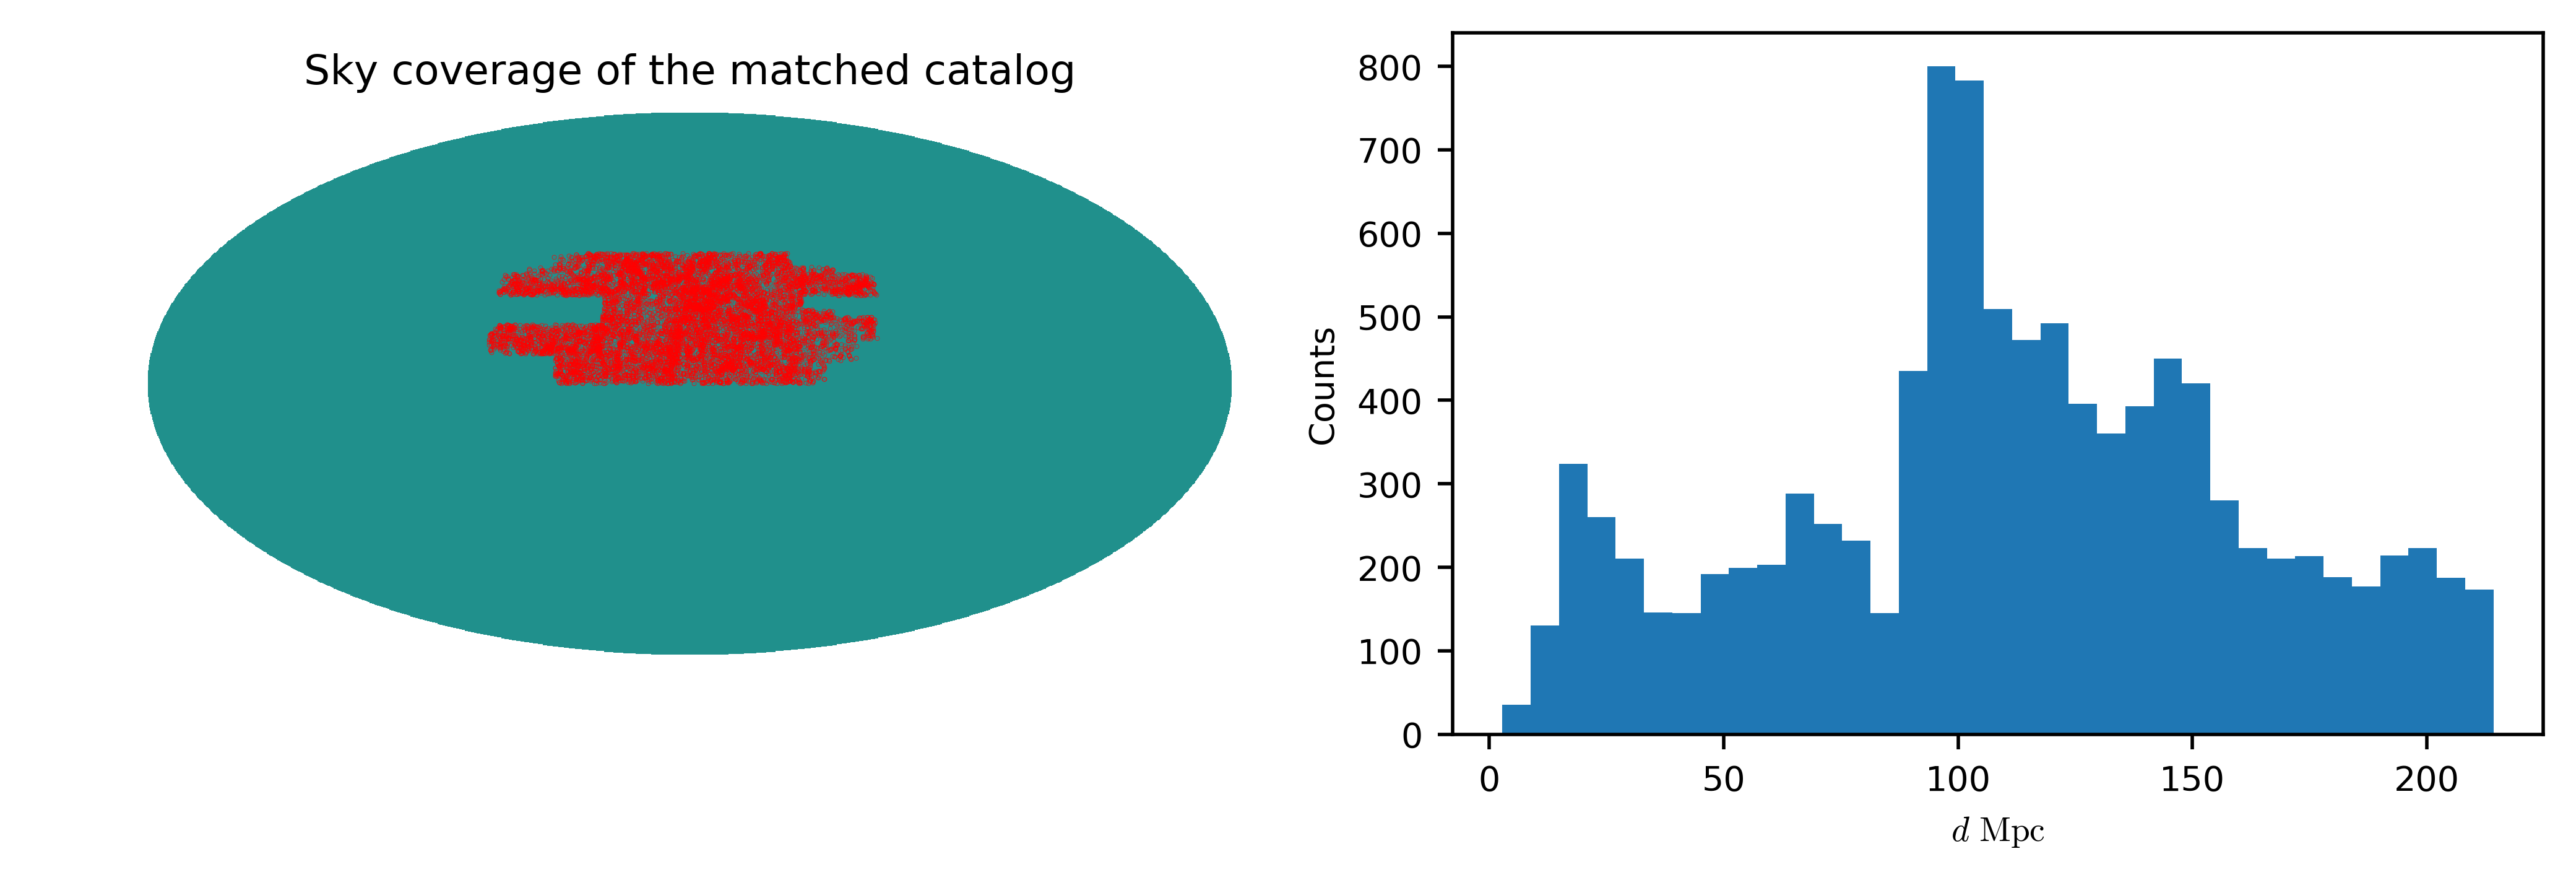

In [107]:
logMH = cat['logMH']
MS = cat['SERSIC_MASS']
RA = cat['RAdeg_HI']
DEC = cat['DECdeg_HI']
Dist = cat['Dist']

IDS = np.where(np.isfinite(MS))

logMH = logMH[IDS]
logMS = np.log10(MS[IDS])
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]


fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=500, figsize=(10, 3))
plt.axes(ax1)
title="Sky coverage of the matched catalog"
hp.mollview(np.zeros(12), rot=180, hold=True, cbar=False, xsize=1600, title=title)
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), c='red', s=0.01)

plt.axes(ax2)
plt.hist(Dist, bins='auto')
plt.ylabel(r"Counts")
plt.xlabel(r"$d\ \mathrm{Mpc}$")

plt.show()

### Inspect the distribution of baryonic mass galaxies in this catalog

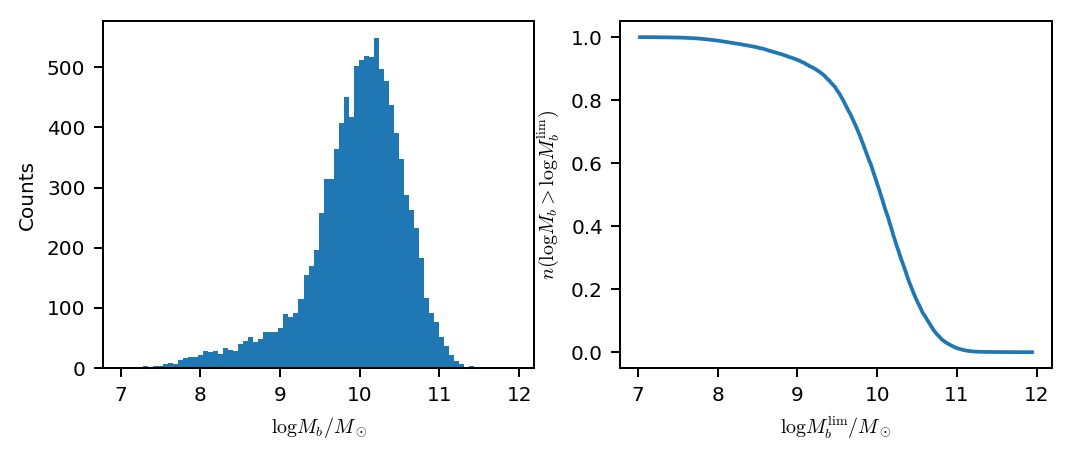

In [108]:
logBM = np.log10(10**logMS+1.4*10**logMH)

def mass_fraction(mass, logBM):
    return np.where(logBM>mass)[0].size/logBM.size

plt.figure(figsize=(2*figwidth,figheight),dpi=180)

plt.subplot(121)
plt.hist(logBM, bins='auto')
plt.xlabel(r"$\log M_b/M_\odot$")
plt.ylabel(r"Counts")

plt.subplot(122)
t = np.linspace(logBM.min(), logBM.max(), 1000)
plt.plot(t, [mass_fraction(i, logBM) for i in t])
plt.xlabel(r"$\log M_{b}^{\mathrm{lim}}/M_\odot$")
plt.ylabel(r"$n(\log M_{b} >\log M_{b}^{\mathrm{lim}})$")

plt.show()

### Calculate how does baryonic mass relate to HI and SM

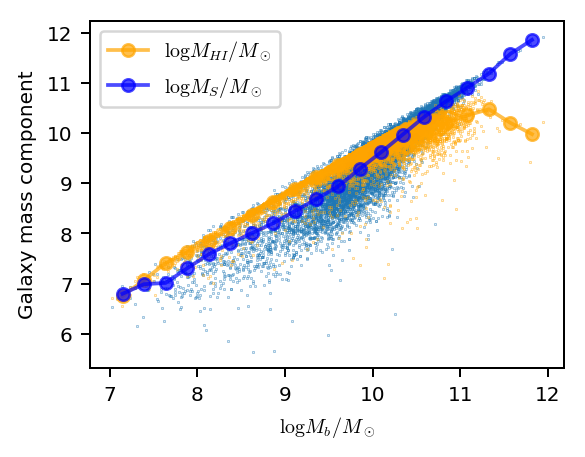

In [203]:
bin_logMHmass, logBMbins, __ = binned_statistic(logBM, 10**logMH, bins=20)
bin_logMSmass, __, __ = binned_statistic(logBM, 10**logMS, bins=20)
bin_logMHmass = np.log10(bin_logMHmass)
bin_logMSmass = np.log10(bin_logMSmass)
xlogBMbins = p.bin_centers(logBMbins)


BM2HIlogmass_func = interp1d(xlogBMbins, bin_logMHmass, kind='cubic')
BM2SMlogmass_func = interp1d(xlogBMbins, bin_logMSmass, kind='cubic')

plt.figure(figsize=(figwidth,figheight),dpi=180)
plt.scatter(logBM, logMS, s=0.025)
plt.scatter(logBM, logMH, s=0.025, c='orange')
plt.plot(xlogBMbins, bin_logMHmass, c='orange', marker='o', alpha=0.7, ms=5, label=r"$\log M_{HI}/M_\odot $")
plt.plot(xlogBMbins, bin_logMSmass, c='blue', marker='o', alpha=0.7, ms=5, label=r"$\log M_S/M_\odot$")
plt.xlabel(r"$\log M_b/M_\odot$")
plt.ylabel(r"Galaxy mass component")
plt.legend()
plt.show()

### Calculate the sky covarage in terms of healpy pixels
For this later might want to include some mass cuts

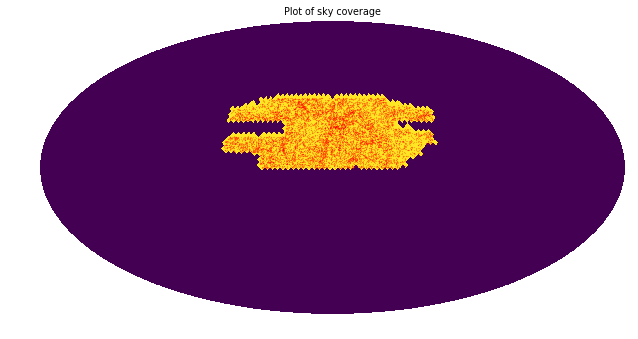

In [116]:
nside = 28
pixs_list = list()

for r, d in zip(np.deg2rad(RA), np.deg2rad(DEC)):
    pix = hp.ang2pix(nside, np.pi/2-d, r)
    pixs_list.append(pix)

pixs_list = np.unique(pixs_list)

coverage_map = np.zeros(hp.nside2npix(nside))
coverage_map[pixs_list] = 1


title = "Plot of sky coverage"
hp.mollview(coverage_map, rot=180, xsize=3000, title=title, cbar=False)
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), c='red', s=0.01)


# Save the active pixels

p.dump_pickle(pixs_list, "../../Data/BMmatching/Pixs_coverage_matchedcat.p")

### Load the generated random catalog and plot it

In [134]:
km_clusters = p.load_pickle("../../Data/BMmatching/Rand_km_clusters.p")
randcat = np.load("../../Data/BMmatching/randCat_match.npy")

randRA = randcat['ra']
randDEC = randcat['dec']
randDist = randcat['dist']

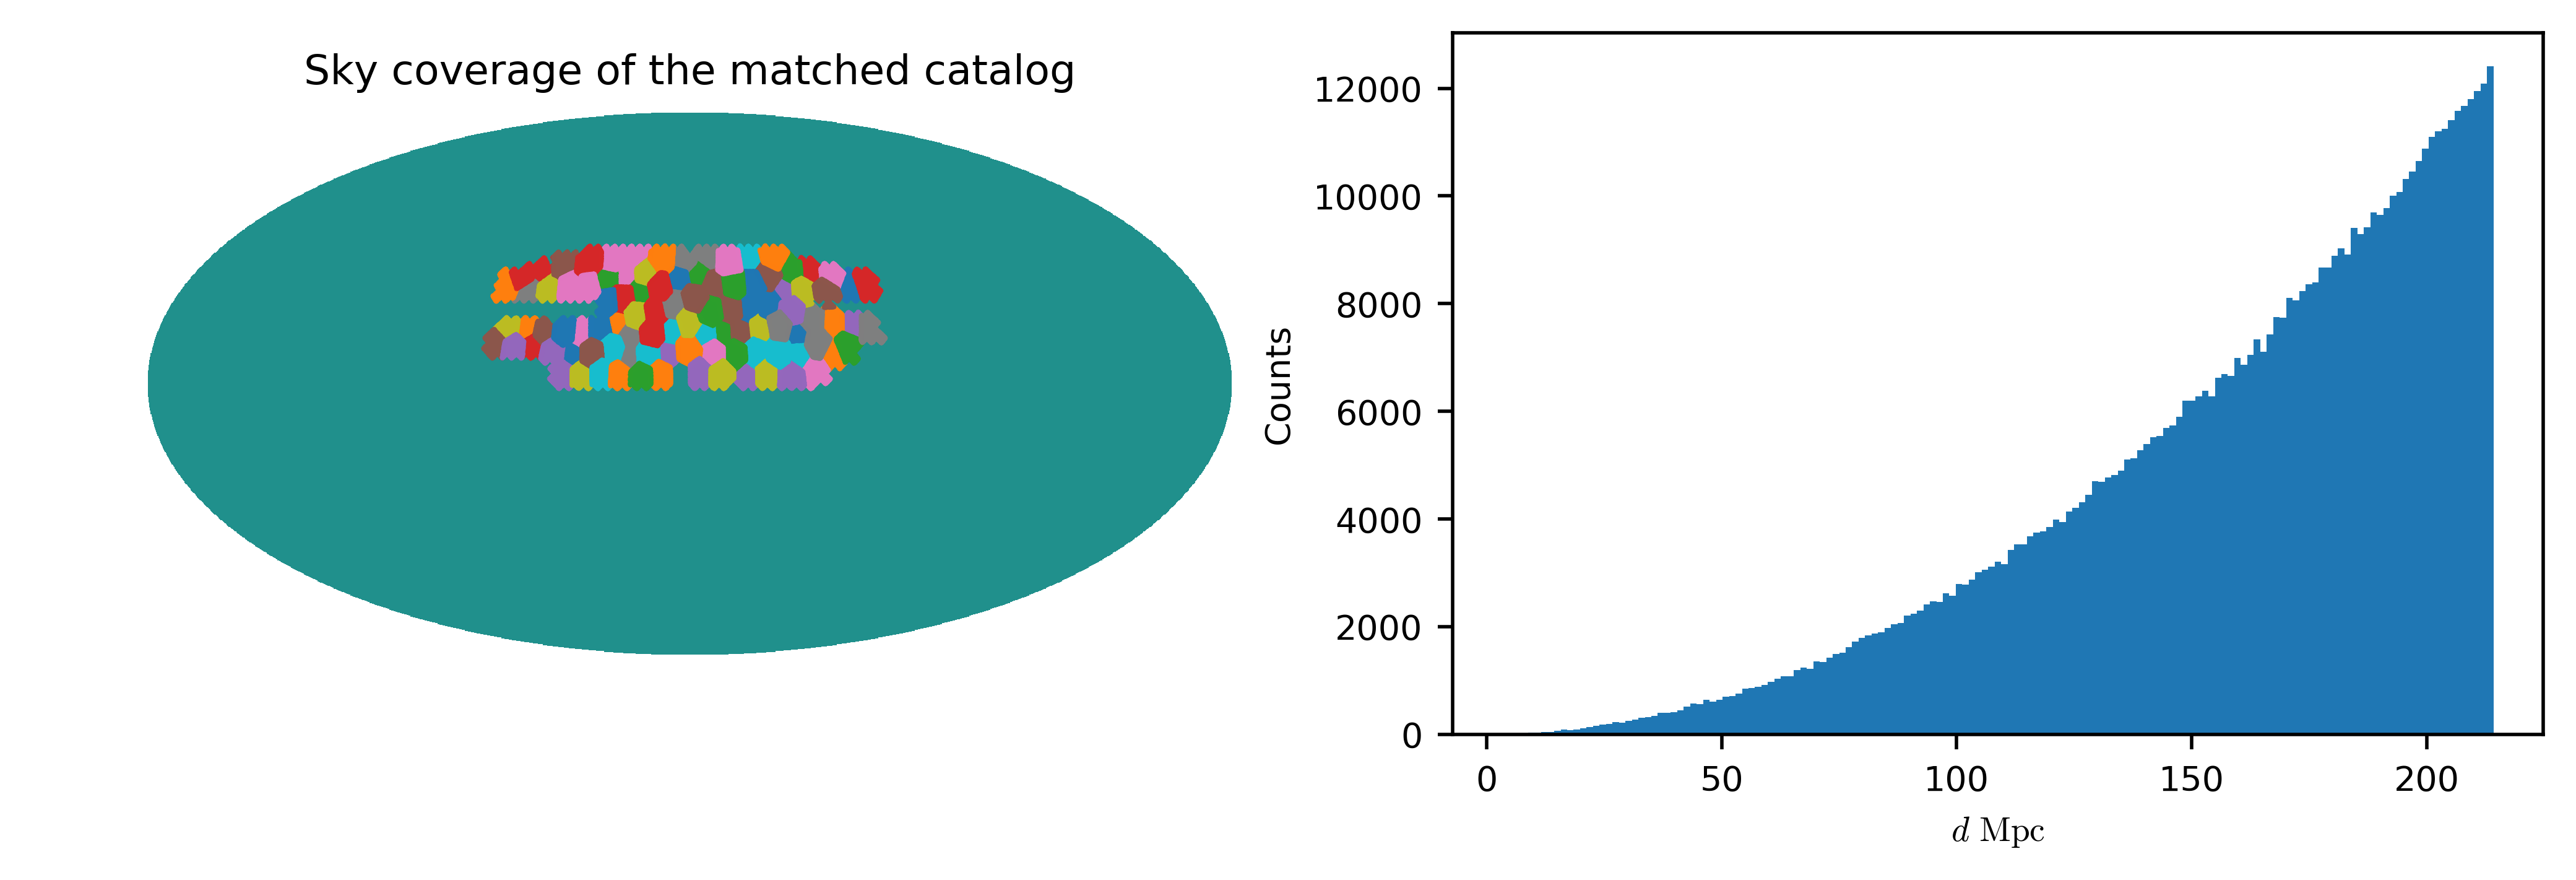

In [136]:
fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=500, figsize=(10, 3))
plt.axes(ax1)
title="Sky coverage of the matched catalog"
hp.mollview(np.zeros(12), rot=180, hold=True, cbar=False, xsize=1600, title=title)
for i in range(km_clusters.labels.max()):
    IDS = np.where(km_clusters.labels == i)
    hp.projscatter(np.pi/2-np.deg2rad(randDEC[IDS]), np.deg2rad(randRA[IDS]), s=0.01)

plt.axes(ax2)
plt.hist(randDist, bins='auto')
plt.ylabel(r"Counts")
plt.xlabel(r"$d\ \mathrm{Mpc}$")

plt.show()

## 6. Apply selection function to the random catalog

### Pick an arbitrary (for now) cut in baryonic mass

In [210]:
logBMlim = 9

IDS = np.where(logBM > logBMlim)

logBMcut = logBM[IDS]
RAcut = RA[IDS]
DECcut = DEC[IDS]
Distcut = Dist[IDS]ss

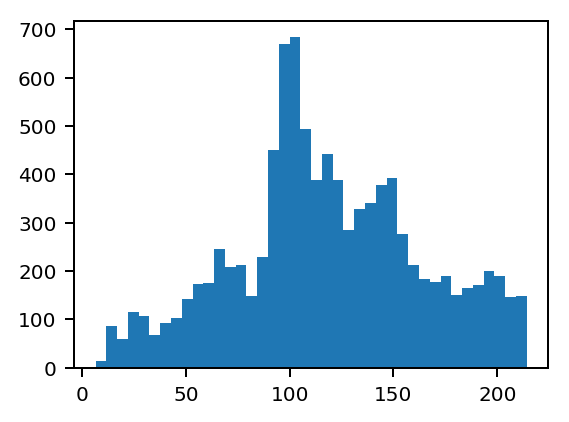

In [212]:
plt.figure(figsize=(figwidth, figheight), dpi=180)
plt.hist(Distcut, bins='auto')
plt.show()

Work out the sky coverage for pixels so that we can generate a random catalog..

Use openMPI for jupyter!!